In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import SegformerForSemanticSegmentation
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import math
import os
import torch 
import torchvision
import torch.nn as nn
import scipy.io
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import re
import cv2
import math
import os
import re
import cv2
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from keras.utils import to_categorical
from tqdm import tqdm
import time
import math
import os
import re
import cv2
import numpy as np
import torch
from keras.utils import to_categorical
import random

In [2]:
!pip install torch torchvision transformers timm

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
def find_numerical_part(string):
    # Use regex to find numerical part in the string
    numerical_part = re.findall(r'\d+', string)[0]
    return numerical_part

def excluding_classes(img, classes_to_exclude):
    indices = np.where(np.isin(img, classes_to_exclude))
    img[indices] = 0   # changes them to background (0)
    return img

n_classes = 32
# classes_to_exclude = list(range(8, 32))  # Classes 8 to 31

class aquatic_plant_dataset:
    def __init__(self, imagePaths, transforms, mode, img_target_shape=512):
        # store the image and mask filepaths, and augmentation
        self.imagePaths = imagePaths
        self.transforms = transforms
        self.mode = mode
        self.train_list = []
        self.val_list = []
        self.test_list = []
        self.target_shape = (img_target_shape, img_target_shape)
        
        if self.mode == 'train':
            root_dir = self.imagePaths
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if 'frame' in directory:
                        self.train_list.append(os.path.join(root, directory))
        
        elif self.mode == 'val':
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if 'frame' in directory:
                        self.val_list.append(os.path.join(root, directory))
                        
        else:
            # Walk through all directories and subdirectories
            for root, dirs, files in os.walk(self.imagePaths):
                for directory in dirs:
                    if 'frame' in directory:
                        self.test_list.append(os.path.join(root, directory))

    def __len__(self):
        if self.mode == 'train':
            return len(self.train_list)
        elif self.mode == 'val':
            return len(self.val_list)
        else:
            return len(self.test_list)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            folder_dir = self.train_list[idx]
        elif self.mode == 'val':
            folder_dir = self.val_list[idx]
        else:
            folder_dir = self.test_list[idx]

        frame_name = folder_dir.split('/')[-1]
        loc_name = folder_dir.split('/')[-2]
        numeral = find_numerical_part(frame_name)
        
        image_path = os.path.join(folder_dir, f'{loc_name}_{numeral}_multiclass.png')  
        multi_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        raw_path = os.path.join(folder_dir, f'frame_{numeral}.jpg')  
        raw_img = cv2.imread(raw_path)  
        
        # Exclude unwanted classes
        multi_mask = excluding_classes(multi_mask, n_classes)
        
        if self.transforms is not None:
            target_size = self.target_shape
            raw_img = cv2.resize(raw_img, target_size, interpolation=cv2.INTER_NEAREST)
            multi_mask = cv2.resize(multi_mask, target_size, interpolation=cv2.INTER_NEAREST)
            
            # Augmentation
            if self.mode == 'train':
                # Random horizontal flip
                if random.random() > 0.5:
                    raw_img = cv2.flip(raw_img, 1)
                    multi_mask = cv2.flip(multi_mask, 1)

                # Random vertical flip
                if random.random() > 0.5:
                    raw_img = cv2.flip(raw_img, 0)
                    multi_mask = cv2.flip(multi_mask, 0)

                # Random rotation
                angle = random.choice([0, 45, 90])
                if angle != 0:
                    center = (target_size[0] // 2, target_size[1] // 2)
                    M = cv2.getRotationMatrix2D(center, angle, 1.0)
                    raw_img = cv2.warpAffine(raw_img, M, target_size)
                    multi_mask = cv2.warpAffine(multi_mask, M, target_size, flags=cv2.INTER_NEAREST)
        
        multi_mask_expand = to_categorical(multi_mask, num_classes=n_classes)
        
        raw_img = np.transpose(raw_img, axes=(2, 0, 1))
        multi_mask_expand = np.transpose(multi_mask_expand, axes=(2, 0, 1))
        
        return torch.from_numpy(raw_img), torch.from_numpy(multi_mask_expand), torch.from_numpy(multi_mask)
              
train_dataset = aquatic_plant_dataset('/kaggle/input/aquavdatasetmain/Stratified_split/Train', True, 'train')
val_dataset = aquatic_plant_dataset('/kaggle/input/aquavdatasetmain/Stratified_split/Validation', True, 'val')
test_dataset = aquatic_plant_dataset('/kaggle/input/aquavdatasetmain/Stratified_split/Test', True, 'test')

In [4]:
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")


In [5]:
from timm.models.swin_transformer import SwinTransformer

# Define the number of classes
num_classes = 32

# Load the Swin Transformer model for semantic segmentation
model = SwinTransformer(
    img_size=512,
    patch_size=4,
    in_chans=3,
    num_classes=num_classes,
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    mlp_ratio=4.,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=False
)

# Move the model to the appropriate device
model = model.to(device)
print(model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [6]:


lossfunc = nn.CrossEntropyLoss()
lr = 1e-4
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=2e-5)

In [7]:
import torch.nn.functional as F

num_epoch = 60

print("Start training the network...")
startTime = time.time()

val_loss = []
train_loss = []

best_loss = math.inf

for epoch in tqdm(range(num_epoch)):
    model.train()
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (raw, gt, _)) in enumerate(train_loader):
        (raw, gt) = (raw.to(device), gt.to(device))
        raw = raw.to(torch.float)
        gt = gt.to(torch.float)
        
        # Remove the class dimension from the target tensor
        gt = torch.argmax(gt, dim=1)
        
        outputs = model(raw)
        logits = outputs  # Extract logits from the model output
        
        # Ensure logits have the correct shape
        if logits.dim() == 2:
            logits = logits.unsqueeze(2).unsqueeze(3)  # Add spatial dimensions if missing
        
        # Resize logits to match the target spatial dimensions
        logits = F.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=False)
        
        loss = lossfunc(logits, gt)

        optim.zero_grad()
        loss.backward()
        optim.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
        
    train_loss.append(totalTrainLoss / len(train_loader))
    
    with torch.no_grad():
        model.eval()
        for (raw, gt, _) in val_loader:
            (raw, gt) = (raw.to(device), gt.to(device))
            raw = raw.to(torch.float)
            gt = gt.to(torch.float)
            
            # Remove the class dimension from the target tensor
            gt = torch.argmax(gt, dim=1)
            
            outputs = model(raw)
            logits = outputs  # Extract logits from the model output
            
            # Ensure logits have the correct shape
            if logits.dim() == 2:
                logits = logits.unsqueeze(2).unsqueeze(3)  # Add spatial dimensions if missing
            
            # Resize logits to match the target spatial dimensions
            logits = F.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=False)
            
            curr_loss = lossfunc(logits, gt)
            totalTestLoss += curr_loss.item()
    val_loss.append(totalTestLoss / len(val_loader)) 
    
    if(totalTestLoss < best_loss):
        print(f'Saving best weight at epoch: {epoch}.......')
        torch.save(model.state_dict(), f'model_weights.pth')    
        best_loss = totalTestLoss
            
    print(f"Train loss: {totalTrainLoss / len(train_loader)}, Val loss: {totalTestLoss / len(val_loader)}")
    
    print("EPOCH: {}/{}".format(epoch + 1, num_epoch))
    
endTime = time.time()
print("total time taken to train the model: {:.2f}s".format(endTime - startTime))

Start training the network...


  2%|▏         | 1/60 [01:04<1:03:32, 64.62s/it]

Saving best weight at epoch: 0.......
Train loss: 1.1476400166749954, Val loss: 1.1276316612958908
EPOCH: 1/60
Saving best weight at epoch: 1.......


  3%|▎         | 2/60 [02:04<59:55, 61.99s/it]  

Train loss: 1.0052358756462734, Val loss: 0.9746544897556305
EPOCH: 2/60
Saving best weight at epoch: 2.......


  5%|▌         | 3/60 [03:04<57:50, 60.89s/it]

Train loss: 0.9446430623531341, Val loss: 0.9578697919845581
EPOCH: 3/60
Saving best weight at epoch: 3.......


  7%|▋         | 4/60 [04:04<56:24, 60.43s/it]

Train loss: 0.9043157736460368, Val loss: 0.9491504848003387
EPOCH: 4/60
Saving best weight at epoch: 4.......


  8%|▊         | 5/60 [05:04<55:15, 60.27s/it]

Train loss: 0.9184065173069637, Val loss: 0.9415509104728699
EPOCH: 5/60
Saving best weight at epoch: 5.......


 10%|█         | 6/60 [06:02<53:49, 59.80s/it]

Train loss: 0.9185793111721675, Val loss: 0.9370643049478531
EPOCH: 6/60


 12%|█▏        | 7/60 [07:02<52:36, 59.55s/it]

Train loss: 0.9018656462430954, Val loss: 0.937171396613121
EPOCH: 7/60
Saving best weight at epoch: 7.......


 13%|█▎        | 8/60 [08:01<51:29, 59.42s/it]

Train loss: 0.8980894108613332, Val loss: 0.9361067116260529
EPOCH: 8/60


 15%|█▌        | 9/60 [08:59<50:20, 59.23s/it]

Train loss: 0.8922017673651378, Val loss: 0.9362313032150269
EPOCH: 9/60
Saving best weight at epoch: 9.......


 17%|█▋        | 10/60 [09:59<49:29, 59.40s/it]

Train loss: 0.8901257356007893, Val loss: 0.9353849232196808
EPOCH: 10/60


 18%|█▊        | 11/60 [10:59<48:39, 59.59s/it]

Train loss: 0.8842252453168233, Val loss: 0.937768530845642
EPOCH: 11/60
Saving best weight at epoch: 11.......


 20%|██        | 12/60 [11:58<47:34, 59.47s/it]

Train loss: 0.8903150101502736, Val loss: 0.9352479487657547
EPOCH: 12/60
Saving best weight at epoch: 12.......


 22%|██▏       | 13/60 [12:58<46:37, 59.53s/it]

Train loss: 0.8714944899082184, Val loss: 0.9284652292728424
EPOCH: 13/60
Saving best weight at epoch: 13.......


 23%|██▎       | 14/60 [13:58<45:48, 59.76s/it]

Train loss: 0.8647037406762441, Val loss: 0.9228355526924134
EPOCH: 14/60


 25%|██▌       | 15/60 [14:58<44:50, 59.79s/it]

Train loss: 0.8812834074099859, Val loss: 0.9538427472114563
EPOCH: 15/60


 27%|██▋       | 16/60 [15:58<43:50, 59.79s/it]

Train loss: 0.8660047014554342, Val loss: 0.9622077822685242
EPOCH: 16/60


 28%|██▊       | 17/60 [16:58<42:49, 59.74s/it]

Train loss: 0.8720471759637197, Val loss: 0.9261007130146026
EPOCH: 17/60


 30%|███       | 18/60 [17:57<41:47, 59.70s/it]

Train loss: 0.8544649342695873, Val loss: 0.9314822316169739
EPOCH: 18/60


 32%|███▏      | 19/60 [18:57<40:44, 59.63s/it]

Train loss: 0.8779020915428798, Val loss: 0.9538303315639496
EPOCH: 19/60


 33%|███▎      | 20/60 [19:56<39:44, 59.62s/it]

Train loss: 0.8940235038598379, Val loss: 0.9368694514036179
EPOCH: 20/60


 35%|███▌      | 21/60 [20:56<38:49, 59.74s/it]

Train loss: 0.8708356817563375, Val loss: 0.9389868795871734
EPOCH: 21/60


 37%|███▋      | 22/60 [21:56<37:50, 59.74s/it]

Train loss: 0.8661693662405014, Val loss: 0.9373161137104035
EPOCH: 22/60


 38%|███▊      | 23/60 [22:56<36:49, 59.73s/it]

Train loss: 0.854012617468834, Val loss: 0.9366640508174896
EPOCH: 23/60


 40%|████      | 24/60 [23:55<35:49, 59.70s/it]

Train loss: 0.8685077925523123, Val loss: 0.9357134819030761
EPOCH: 24/60


 42%|████▏     | 25/60 [24:55<34:49, 59.70s/it]

Train loss: 0.8722185959418615, Val loss: 0.9348589837551117
EPOCH: 25/60


 43%|████▎     | 26/60 [25:55<33:46, 59.61s/it]

Train loss: 0.8474199712276459, Val loss: 0.9341854453086853
EPOCH: 26/60


 45%|████▌     | 27/60 [26:54<32:42, 59.47s/it]

Train loss: 0.9251136293013891, Val loss: 0.9685540229082108
EPOCH: 27/60


 47%|████▋     | 28/60 [27:53<31:39, 59.35s/it]

Train loss: 0.8628805836041769, Val loss: 0.9385368376970291
EPOCH: 28/60


 48%|████▊     | 29/60 [28:52<30:39, 59.33s/it]

Train loss: 0.8625812272230784, Val loss: 0.9378983318805695
EPOCH: 29/60


 50%|█████     | 30/60 [29:51<29:40, 59.36s/it]

Train loss: 0.8712110946575801, Val loss: 0.9370702862739563
EPOCH: 30/60


 52%|█████▏    | 31/60 [30:51<28:41, 59.37s/it]

Train loss: 0.8644511312246322, Val loss: 0.9376558870077133
EPOCH: 31/60


 53%|█████▎    | 32/60 [31:50<27:43, 59.43s/it]

Train loss: 0.8636964946985245, Val loss: 0.9367598801851272
EPOCH: 32/60


 55%|█████▌    | 33/60 [32:50<26:45, 59.46s/it]

Train loss: 0.8439700404802958, Val loss: 0.9377358496189118
EPOCH: 33/60


 57%|█████▋    | 34/60 [33:49<25:46, 59.48s/it]

Train loss: 0.8583330601453781, Val loss: 0.9373307824134827
EPOCH: 34/60


 58%|█████▊    | 35/60 [34:49<24:49, 59.58s/it]

Train loss: 0.8721922387679418, Val loss: 0.9378053843975067
EPOCH: 35/60


 60%|██████    | 36/60 [35:49<23:48, 59.52s/it]

Train loss: 0.8449951241413752, Val loss: 0.9375120669603347
EPOCH: 36/60


 62%|██████▏   | 37/60 [36:48<22:47, 59.44s/it]

Train loss: 0.8562828143437703, Val loss: 0.9376057922840119
EPOCH: 37/60


 63%|██████▎   | 38/60 [37:47<21:46, 59.38s/it]

Train loss: 0.8464269896348318, Val loss: 0.9364222109317779
EPOCH: 38/60


 65%|██████▌   | 39/60 [38:47<20:49, 59.49s/it]

Train loss: 0.8584948221842448, Val loss: 0.9368113785982132
EPOCH: 39/60


 67%|██████▋   | 40/60 [39:47<19:52, 59.60s/it]

Train loss: 0.8554031074047088, Val loss: 0.9374908238649369
EPOCH: 40/60


 68%|██████▊   | 41/60 [40:47<18:53, 59.66s/it]

Train loss: 0.8501141548156739, Val loss: 0.9358531892299652
EPOCH: 41/60


 70%|███████   | 42/60 [41:46<17:53, 59.63s/it]

Train loss: 0.8581010768810908, Val loss: 0.9359492391347886
EPOCH: 42/60


 72%|███████▏  | 43/60 [42:46<16:54, 59.68s/it]

Train loss: 0.8415551473697026, Val loss: 0.9349635720252991
EPOCH: 43/60


 73%|███████▎  | 44/60 [43:46<15:55, 59.75s/it]

Train loss: 0.8423191348711649, Val loss: 0.9328579992055893
EPOCH: 44/60


 75%|███████▌  | 45/60 [44:46<14:56, 59.78s/it]

Train loss: 0.8361133793989818, Val loss: 0.9312909722328186
EPOCH: 45/60


 77%|███████▋  | 46/60 [45:45<13:55, 59.68s/it]

Train loss: 0.8405797829230627, Val loss: 0.9487019926309586
EPOCH: 46/60
Saving best weight at epoch: 46.......


 78%|███████▊  | 47/60 [46:45<12:57, 59.77s/it]

Train loss: 0.8324928492307663, Val loss: 0.9140227675437927
EPOCH: 47/60


 80%|████████  | 48/60 [47:44<11:55, 59.59s/it]

Train loss: 0.8673387120167414, Val loss: 0.9394859135150909
EPOCH: 48/60


 82%|████████▏ | 49/60 [48:44<10:54, 59.51s/it]

Train loss: 0.8509613792101542, Val loss: 0.9351714015007019
EPOCH: 49/60


 83%|████████▎ | 50/60 [49:43<09:55, 59.53s/it]

Train loss: 0.8611448248227437, Val loss: 0.9324449151754379
EPOCH: 50/60


 85%|████████▌ | 51/60 [50:43<08:55, 59.55s/it]

Train loss: 0.833195436000824, Val loss: 0.9334700226783752
EPOCH: 51/60


 87%|████████▋ | 52/60 [51:42<07:56, 59.51s/it]

Train loss: 0.8129541675249735, Val loss: 0.9588539600372314
EPOCH: 52/60


 88%|████████▊ | 53/60 [52:41<06:55, 59.41s/it]

Train loss: 0.8273291021585465, Val loss: 0.933039516210556
EPOCH: 53/60
Saving best weight at epoch: 53.......


 90%|█████████ | 54/60 [53:41<05:56, 59.43s/it]

Train loss: 0.8114162713289261, Val loss: 0.9037014216184616
EPOCH: 54/60
Saving best weight at epoch: 54.......


 92%|█████████▏| 55/60 [54:41<04:57, 59.54s/it]

Train loss: 0.8125733594099681, Val loss: 0.90003043115139
EPOCH: 55/60


 93%|█████████▎| 56/60 [55:40<03:57, 59.50s/it]

Train loss: 0.8051638255516688, Val loss: 0.9109187811613083
EPOCH: 56/60


 95%|█████████▌| 57/60 [56:39<02:58, 59.42s/it]

Train loss: 0.799193795522054, Val loss: 0.9121444821357727
EPOCH: 57/60


 97%|█████████▋| 58/60 [57:38<01:58, 59.34s/it]

Train loss: 0.7968195577462515, Val loss: 0.9034736186265946
EPOCH: 58/60


 98%|█████████▊| 59/60 [58:38<00:59, 59.26s/it]

Train loss: 0.7785393178462983, Val loss: 0.9156030088663101
EPOCH: 59/60


100%|██████████| 60/60 [59:37<00:00, 59.62s/it]

Train loss: 0.7949864407380421, Val loss: 0.9024204909801483
EPOCH: 60/60
total time taken to train the model: 3577.30s


In [8]:
# Evaluation functions
def dice_coefficient(ground_truth, predicted, num_classes):
    dice_scores = []
    
    for class_label in range(0, num_classes):
        ground_truth_np = ground_truth.cpu().numpy()
        predicted_np = predicted.cpu().numpy()
        
        intersection = np.sum((ground_truth_np == class_label) & (predicted_np == class_label))
        union = np.sum((ground_truth_np == class_label) | (predicted_np == class_label))
        
        dice = (2.0 * intersection) / (union + intersection + 1e-8)
        dice_scores.append(dice)
    
    avg_dice = np.sum(dice_scores) / len(np.unique(ground_truth.cpu().numpy()))
    
    return avg_dice, dice_scores

def jaccard_index(ground_truth, predicted, num_classes):
    intersection = torch.zeros(num_classes)
    union = torch.zeros(num_classes)
    
    for class_label in range(0, num_classes):
        intersection[class_label] = torch.sum(torch.logical_and(ground_truth == class_label, predicted == class_label))
        union[class_label] = torch.sum(torch.logical_or(ground_truth == class_label, predicted == class_label))
        union[class_label] += 1e-8
    
    jaccard_per_class = intersection / union
    
    avg_jaccard = torch.sum(jaccard_per_class) / len(np.unique(ground_truth.cpu().numpy()))
    
    return avg_jaccard.item(), jaccard_per_class.numpy() 

def calc_accuracy(ground_truth, predicted):
    ground_truth_flat = ground_truth.view(-1)
    correct_predictions = torch.sum(ground_truth == predicted).item()
    total_pixels = ground_truth_flat.shape[0]
    accuracy = correct_predictions / total_pixels
    return accuracy

def multilabel_f1_score(ground_truth, predicted, average='weighted'):
    ground_truth_flat = ground_truth.view(-1)
    predicted_flat = predicted.view(-1)
    
    ground_truth_np = ground_truth_flat.cpu().numpy()
    predicted_np = predicted_flat.cpu().numpy()
    
    f1 = f1_score(ground_truth_np, predicted_np, average=average)
    
    return f1


In [9]:
# Evaluation loop
with torch.no_grad():
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    jaccard_score = 0
    acc = 0
    f1score = 0
    j_class_all = torch.zeros([32])
    d_class_all = np.zeros([32])
    model.eval()
    for i, (raw, _, gt) in enumerate(test_loader):
        (raw, gt) = (raw.to(device), gt.to(device))
        raw = raw.to(torch.float)
        gt = gt.to(torch.float)
        
        outputs = model(raw)
        logits = outputs
        
        # Ensure logits have the correct shape
        if logits.dim() == 2:
            logits = logits.unsqueeze(2).unsqueeze(3)  
        
        # Resize logits to match the target spatial dimensions
        logits = F.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=False)
        
        softmax = nn.Softmax(dim=1)
        pred = torch.argmax(softmax(logits), dim=1)
        
        gt = gt.to(torch.uint8)
        pred = pred.to(torch.uint8)
        dice, dice_class = dice_coefficient(gt, pred, 32)
        jaccard, j_class = jaccard_index(gt, pred, 32)
        accuracy = calc_accuracy(gt, pred)
        f1 = multilabel_f1_score(gt, pred)
        
        dice_score += dice
        jaccard_score += jaccard
        acc += accuracy
        f1score += f1
        
        j_class_all += j_class
        d_class_all += dice_class

print(f"Total Dice co-efficient is {dice_score / (i + 1)}, jaccard index is {jaccard_score / (i + 1)}, accuracy: {acc / (i + 1)}, F1 score: {f1score / (i + 1)}")



Total Dice co-efficient is 0.24010929075409088, jaccard index is 0.22147633284330367, accuracy: 0.7715299987792968, F1 score: 0.6978487857280927


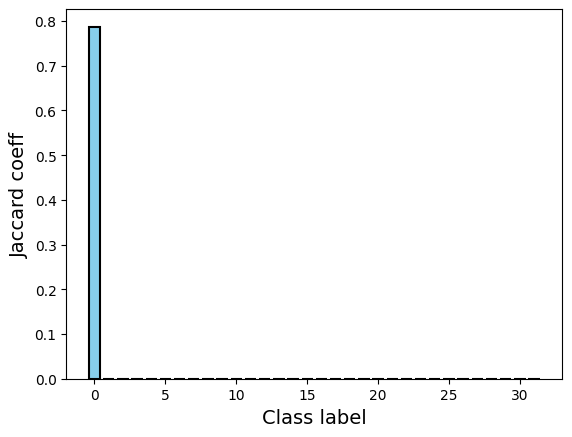

In [10]:
classwisescore = j_class_all / i

plt.bar(range(len(classwisescore)), classwisescore, color='skyblue', edgecolor='black', linewidth=1.5)
plt.xlabel('Class label', fontsize=14)
plt.ylabel('Jaccard coeff', fontsize=14)
plt.savefig('jaccard_classwise.png', dpi=600) 
plt.show()

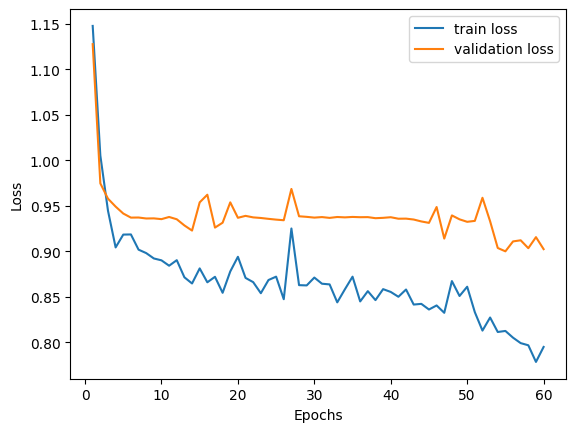

In [11]:
# Plotting the loss curves
x = list(range(1, len(train_loss) + 1))  
plt.plot(x, train_loss, label='train')  # Plot the first line and specify its label
plt.plot(x, val_loss, label='val')  # Plot the second line and specify its label

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss', 'validation loss'])
plt.savefig('loss_curve_multiclass.png', dpi=300) 
plt.show()
    